# Import und Grundkonfiguration

In [2]:
from ultralytics import YOLO
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Matplotlib etwas hübscher
plt.style.use("seaborn-v0_8")

# Modell laden

In [4]:
# Kleines YOLOv8-Modell (reicht für dein Projekt, schnell)
model = YOLO("yolov8n.pt")

# Klassen-Namen (COCO)
CLASS_NAMES = model.names  # dict: {0: 'person', 1: 'bicycle', ...}

# COCO-Klasse für Fahrrad
BIKE_CLASS_ID = 1

print("Modell geladen.")
print("Anzahl Klassen:", len(CLASS_NAMES))
print("Fahrrad-Klassen-ID:", BIKE_CLASS_ID, "→", CLASS_NAMES[BIKE_CLASS_ID])

Modell geladen.
Anzahl Klassen: 80
Fahrrad-Klassen-ID: 1 → bicycle


# Video importieren

## Videopfad definieren

In [8]:
VIDEO_PATH = "data/velopark1.mp4"

video_path = Path(VIDEO_PATH)
if not video_path.exists():
    raise FileNotFoundError(f"Video nicht gefunden: {video_path}")
else:
    print("Verwendetes Video:", video_path)


Verwendetes Video: data/velopark1.mp4


# Detections extrahieren

In [9]:
# Zelle 4: Funktion, um alle Detections aus einem Video zu extrahieren

def extract_detections(video_path, max_frames=None, conf_threshold=0.0):
    """
    Lädt ein Video und schreibt JEDE YOLO-Detection in ein DataFrame.
    
    Parameter
    ---------
    video_path : str oder Path
        Pfad zum Video.
    max_frames : int oder None
        Wenn gesetzt, werden nur die ersten max_frames Frames verarbeitet.
    conf_threshold : float
        Nur Detections mit Konfidenz >= conf_threshold werden übernommen.
    
    Rückgabe
    --------
    df : pandas.DataFrame
        Eine Zeile pro Detection, Spalten u.a.:
        frame, cls_id, cls_name, conf, x1, y1, x2, y2, width, height, area, is_bike
    """
    video_path = Path(video_path)
    if not video_path.exists():
        raise FileNotFoundError(video_path)

    cap = cv2.VideoCapture(str(video_path))

    records = []
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if max_frames is not None and frame_idx >= max_frames:
            break

        # YOLO-Inferenz
        results = model.predict(frame, verbose=False)
        boxes = results[0].boxes

        if boxes is not None and len(boxes) > 0:
            clses = boxes.cls.cpu().numpy().astype(int)
            confs = boxes.conf.cpu().numpy()
            xyxy = boxes.xyxy.cpu().numpy()

            for cls_id, conf, (x1, y1, x2, y2) in zip(clses, confs, xyxy):
                if conf < conf_threshold:
                    continue

                x1, y1, x2, y2 = map(float, [x1, y1, x2, y2])
                w = x2 - x1
                h = y2 - y1
                area = w * h

                records.append({
                    "frame": frame_idx,
                    "cls_id": cls_id,
                    "cls_name": CLASS_NAMES.get(cls_id, str(cls_id)),
                    "conf": float(conf),
                    "x1": x1, "y1": y1, "x2": x2, "y2": y2,
                    "width": w,
                    "height": h,
                    "area": area,
                    "is_bike": (cls_id == BIKE_CLASS_ID),
                })

        frame_idx += 1

    cap.release()
    df = pd.DataFrame(records)
    return df

# Ausführen und Basisausgabe

In [11]:
df_det = extract_detections(video_path, max_frames=None, conf_threshold=0.0)
df_bikes = df_det[df_det["is_bike"]].copy()

print("✅ Verarbeitung abgeschlossen.")
print("Anzahl aller Detections:", len(df_det))
print("Anzahl Fahrrad-Detections:", len(df_bikes))

if not df_bikes.empty:
    # Anzahl Frames mit mindestens einem Velo
    frames_mit_bikes = df_bikes["frame"].nunique()
    # Anzahl Velos pro Frame
    bike_counts = df_bikes.groupby("frame")["cls_id"].count()
    print("Frames mit mindestens einem Velo:", frames_mit_bikes)
    print("Maximale gleichzeitige Velos in einem Frame:", bike_counts.max())
    print("Durchschnittliche Velobelegung pro Frame (nur Frames mit Bikes):", bike_counts.mean())
else:
    print("⚠️ Keine Velos erkannt – prüfe Video oder Threshold.")

✅ Verarbeitung abgeschlossen.
Anzahl aller Detections: 2054
Anzahl Fahrrad-Detections: 1221
Frames mit mindestens einem Velo: 269
Maximale gleichzeitige Velos in einem Frame: 11
Durchschnittliche Velobelegung pro Frame (nur Frames mit Bikes): 4.5390334572490705


# Visualisierung

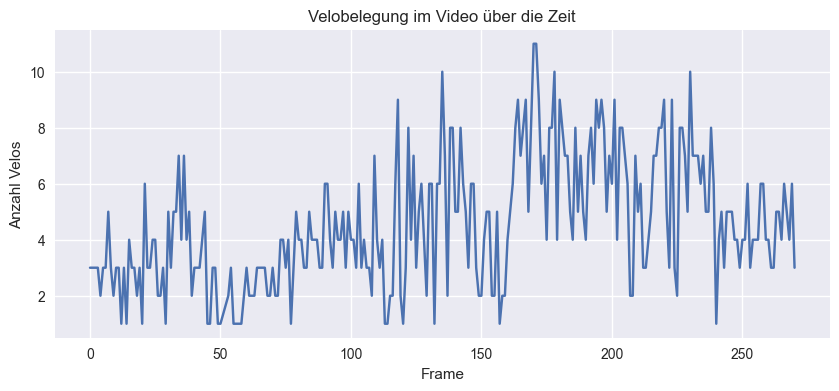

In [12]:
# Zelle 6a: Velobelegung über die Zeit

if not df_bikes.empty:
    bike_counts = df_bikes.groupby("frame")["cls_id"].count()

    plt.figure(figsize=(10,4))
    plt.plot(bike_counts.index, bike_counts.values)
    plt.xlabel("Frame")
    plt.ylabel("Anzahl Velos")
    plt.title("Velobelegung im Video über die Zeit")
    plt.grid(True)
    plt.show()
else:
    print("Keine Bike-Daten zum Plotten vorhanden.")

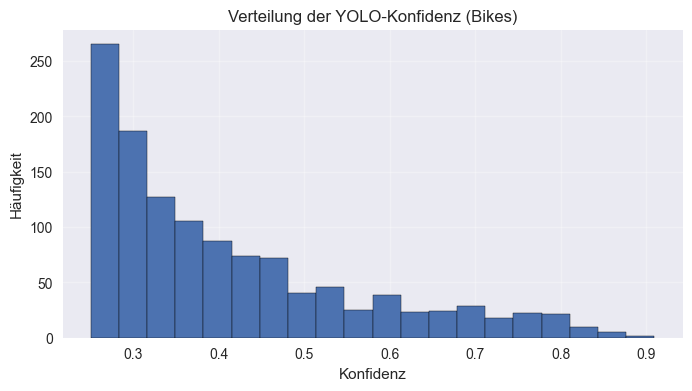

In [13]:
if not df_bikes.empty:
    plt.figure(figsize=(8,4))
    plt.hist(df_bikes["conf"], bins=20, edgecolor="black")
    plt.xlabel("Konfidenz")
    plt.ylabel("Häufigkeit")
    plt.title("Verteilung der YOLO-Konfidenz (Bikes)")
    plt.grid(True, alpha=0.3)
    plt.show()


# Debug

In [15]:
def show_bikes_in_frame(video_path, frame_idx_to_show):
    cap = cv2.VideoCapture(str(video_path))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx_to_show)

    ret, frame = cap.read()
    if not ret:
        print(f"Frame {frame_idx_to_show} konnte nicht gelesen werden.")
        cap.release()
        return

    results = model.predict(frame, verbose=False)
    boxes = results[0].boxes

    bike_infos = []

    if boxes is not None and len(boxes) > 0:
        clses = boxes.cls.cpu().numpy().astype(int)
        confs = boxes.conf.cpu().numpy()
        xyxy = boxes.xyxy.cpu().numpy()

        for cls_id, conf, (x1, y1, x2, y2) in zip(clses, confs, xyxy):
            if cls_id == BIKE_CLASS_ID:
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                label = f"bike {conf:.2f}"
                bike_infos.append(label)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(
                    frame, label, (x1, max(y1 - 5, 15)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1, cv2.LINE_AA
                )

    print(f"\n=== Frame {frame_idx_to_show} ===")
    if bike_infos:
        print("Anzahl Velos:", len(bike_infos))
        for bi in bike_infos:
            print("   ", bi)
    else:
        print("Keine Velos erkannt.")

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6,4))
    plt.imshow(frame_rgb)
    plt.title(f"Frame {frame_idx_to_show}")
    plt.axis("off")
    plt.show()

    cap.release()


=== Frame 150 ===
Anzahl Velos: 2
    bike 0.30
    bike 0.25


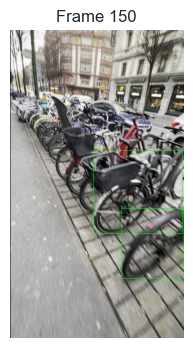

In [16]:
show_bikes_in_frame(video_path, frame_idx_to_show=150)

# Unique Bike Counting

In [20]:
# Zelle 8: Unique-Bike-Counting mit Tracking (ByteTrack)

def track_unique_bikes(video_path, conf_threshold=0.0):
    """
    Verwendet YOLOv8 + Tracking (ByteTrack), um über das ganze Video hinweg
    unterschiedliche Velos zu zählen.

    Parameter
    ---------
    video_path : str oder Path
        Pfad zum Video.
    conf_threshold : float
        Mindestkonfidenz für Berücksichtigung einer Velo-Detection.

    Rückgabe
    --------
    unique_ids : set[int]
        Menge aller unterschiedlichen Tracking-IDs von Velos.
    df_track : pandas.DataFrame
        DataFrame mit Spalten:
        - frame: Frame-Index
        - bike_count_tracked: Anzahl getrackter Velos in diesem Frame
    """
    video_path = Path(video_path)
    if not video_path.exists():
        raise FileNotFoundError(video_path)

    unique_ids = set()
    frame_indices = []
    frame_counts = []

    # YOLO track() liest das Video selbst ein.
    # stream=True -> wir iterieren frameweise über die Resultate
    results = model.track(
        source=str(video_path),
        stream=True,
        persist=True,   # sorgt dafür, dass IDs über Frames erhalten bleiben
        verbose=False
    )

    for frame_idx, res in enumerate(results):
        boxes = res.boxes

        if boxes is None or len(boxes) == 0:
            frame_indices.append(frame_idx)
            frame_counts.append(0)
            continue

        clses = boxes.cls.cpu().numpy().astype(int)
        confs = boxes.conf.cpu().numpy()
        ids = boxes.id
        if ids is None:
            # Falls aus irgendeinem Grund keine IDs da sind
            frame_indices.append(frame_idx)
            frame_counts.append(0)
            continue

        ids = ids.cpu().numpy().astype(int)

        # Filter nur Bikes, über Konfidenz-Threshold
        mask = (clses == BIKE_CLASS_ID) & (confs >= conf_threshold)
        bike_ids_frame = ids[mask]

        # IDs in die globale Menge eintragen
        for bid in bike_ids_frame:
            unique_ids.add(int(bid))

        frame_indices.append(frame_idx)
        frame_counts.append(len(bike_ids_frame))

    df_track = pd.DataFrame({
        "frame": frame_indices,
        "bike_count_tracked": frame_counts
    })

    return unique_ids, df_track

In [22]:
unique_ids, df_track = track_unique_bikes(video_path, conf_threshold=0.3)

print("✅ Tracking abgeschlossen.")
print("Anzahl unterschiedlicher Velos im Video (Unique Bikes):", len(unique_ids))
print()
print("Beispiel aus df_track:")
display(df_track.head())

✅ Tracking abgeschlossen.
Anzahl unterschiedlicher Velos im Video (Unique Bikes): 37

Beispiel aus df_track:


,frame,bike_count_tracked
0,0,1
1,1,1
2,2,2
3,3,1
4,4,2


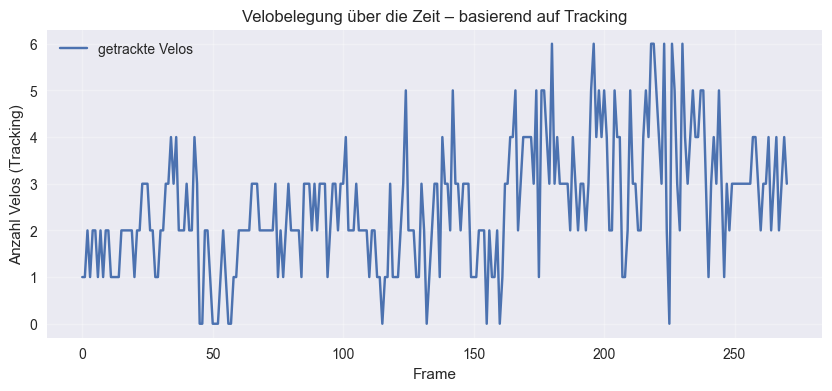

In [23]:
plt.figure(figsize=(10,4))
plt.plot(df_track["frame"], df_track["bike_count_tracked"], label="getrackte Velos")
plt.xlabel("Frame")
plt.ylabel("Anzahl Velos (Tracking)")
plt.title("Velobelegung über die Zeit – basierend auf Tracking")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Video export

In [25]:
from pathlib import Path
import cv2

def create_annotated_bike_video(input_path, output_path=None, conf_threshold=0.0):
    input_path = Path(input_path)
    print(f"[INFO] Eingabepfad: {input_path}")

    if not input_path.exists():
        raise FileNotFoundError(f"Video nicht gefunden: {input_path}")

    if output_path is None:
        output_path = input_path.with_name(input_path.stem + "_bikes_conf.mp4")
    else:
        output_path = Path(output_path)

    print(f"[INFO] Ausgabepfad: {output_path}")

    cap = cv2.VideoCapture(str(input_path))
    if not cap.isOpened():
        raise RuntimeError(f"Konnte Video nicht öffnen: {input_path}")

    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print(f"[INFO] FPS: {fps}, Width: {width}, Height: {height}")

    # Fallback, falls FPS 0 sind
    if fps == 0:
        fps = 25
        print("[WARN] FPS war 0 – setze 25 FPS als Standard.")

    if width == 0 or height == 0:
        raise RuntimeError("Breite oder Höhe des Videos sind 0 – Video defekt oder nicht lesbar?")

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))

    if not out.isOpened():
        raise RuntimeError(f"Konnte VideoWriter nicht initialisieren für: {output_path}")

    frame_idx = 0
    processed_frames = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            print("[INFO] Keine weiteren Frames – breche Schleife.")
            break

        results = model.predict(frame, verbose=False)
        boxes = results[0].boxes

        if boxes is not None and len(boxes) > 0:
            clses = boxes.cls.cpu().numpy().astype(int)
            confs = boxes.conf.cpu().numpy()
            xyxy = boxes.xyxy.cpu().numpy()

            for cls_id, conf, (x1, y1, x2, y2) in zip(clses, confs, xyxy):
                if cls_id == BIKE_CLASS_ID and conf >= conf_threshold:
                    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                    label = f"bike {conf:.2f}"
                    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(
                        frame, label, (x1, max(y1 - 5, 15)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (0, 255, 0), 1, cv2.LINE_AA
                    )

        # Frame-Index einblenden
        cv2.putText(
            frame, f"Frame {frame_idx}", (10, 25),
            cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2, cv2.LINE_AA
        )

        out.write(frame)
        frame_idx += 1
        processed_frames += 1

        if frame_idx % 50 == 0:
            print(f"[INFO] {frame_idx} Frames verarbeitet...")

    cap.release()
    out.release()
    print(f"[INFO] Verarbeitete Frames total: {processed_frames}")
    print(f"🎥 Annotiertes Video gespeichert unter: {output_path}")

In [27]:
create_annotated_bike_video("data/velopark2.mp4", conf_threshold=0.3)

[INFO] Eingabepfad: data/velopark2.mp4
[INFO] Ausgabepfad: data/velopark2_bikes_conf.mp4
[INFO] FPS: 29.987534872677628, Width: 1080, Height: 1920
[INFO] 50 Frames verarbeitet...
[INFO] 100 Frames verarbeitet...
[INFO] 150 Frames verarbeitet...
[INFO] 200 Frames verarbeitet...
[INFO] 250 Frames verarbeitet...
[INFO] 300 Frames verarbeitet...
[INFO] 350 Frames verarbeitet...
[INFO] 400 Frames verarbeitet...
[INFO] 450 Frames verarbeitet...
[INFO] 500 Frames verarbeitet...
[INFO] 550 Frames verarbeitet...
[INFO] 600 Frames verarbeitet...
[INFO] 650 Frames verarbeitet...
[INFO] 700 Frames verarbeitet...
[INFO] 750 Frames verarbeitet...
[INFO] 800 Frames verarbeitet...
[INFO] Keine weiteren Frames – breche Schleife.
[INFO] Verarbeitete Frames total: 842
🎥 Annotiertes Video gespeichert unter: data/velopark2_bikes_conf.mp4
